# Análise dos dados temporais de poluição no estado de São Paulo (2015-2021)

Fonte dos dados: IEMA (Instituto de Energia e Meio Ambiente)

Link: https://energiaeambiente.org.br/qualidadedoar#secao-14

## Importando bibliotecas

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandasql import sqldf

In [2]:
query = lambda q: sqldf(q, globals())

## Importando os dados

In [3]:
years = [str(y) for y in range(2015, 2022)] 

In [4]:
sp_pol = {}

# Unindo dados do mesmo ano.
for y in years:
    first_df = pd.read_csv(f'data/SP{y}01.csv', encoding = 'latin-1')
    sec_df = pd.read_csv(f'data/SP{y}02.csv', encoding = 'latin-1')
    sp_pol[y] = pd.concat([first_df, sec_df])

# Agora uniremos todos os dados em um mesmo dataframe que, por simplicidade, chamaremos de data.
data = sp_pol[years[0]]
    
for y in years[1:]:
    data = pd.concat([data, sp_pol[y]])

data.reset_index(drop = True, inplace = True)
data['ID'] = list(data.index)
cols = data.columns.tolist()
cols = cols[-1:] + cols[:-1]
data = data[cols]

In [5]:
station_code = data[['Estacao', 'Codigo']]

### Salvando os dados reunidos em um único arquivo .csv

In [6]:
#data.to_csv('data/SP_poluicao_dados.csv')

---

## Data Profiling: visão e estatísticas gerais

### Quantidade de linhas e colunas

In [7]:
print(f'(linhas, colunas) : {data.shape}')

(linhas, colunas) : (10980515, 9)


### Descrição das colunas

In [8]:
data.dtypes

ID            int64
Data         object
Hora         object
Estacao      object
Codigo       object
Poluente     object
Valor       float64
Unidade      object
Tipo         object
dtype: object

__ID__: identificação, via índice inteiro, de cada registro do dataframe.

__Data__: data em que foi feita a medição da concentração do poluente.

__Hora__: hora em que foi feita a medição.

__Estação__: local em que foi feita a medição.

__Código__: código associado à estação em que foi realizada a medição.

__Poluente__: poluente cuja concentração foi medida.

__Valor__: valor, na unidade especificada, da concentração do poluente.

__Unidade__: unidade de concentração utilizada.

__Tipo__: como foi realizada a medição (de forma automática ou manual)

### Valores iniciais e finais do dataframe

In [9]:
data.head(5)

,ID,Data,Hora,Estacao,Codigo,Poluente,Valor,Unidade,Tipo
0,0,2015-01-01,01:00,Americana - Vila Santa Maria,SP01,MP10,65.0,ug/m3,automatica
1,1,2015-01-01,02:00,Americana - Vila Santa Maria,SP01,MP10,98.0,ug/m3,automatica
2,2,2015-01-01,03:00,Americana - Vila Santa Maria,SP01,MP10,79.0,ug/m3,automatica
3,3,2015-01-01,04:00,Americana - Vila Santa Maria,SP01,MP10,53.0,ug/m3,automatica
4,4,2015-01-01,05:00,Americana - Vila Santa Maria,SP01,MP10,35.0,ug/m3,automatica


In [10]:
data.tail(5)

,ID,Data,Hora,Estacao,Codigo,Poluente,Valor,Unidade,Tipo
10980510,10980510,2021-02-01,01:00,Tatuapé,SP76,SO2,3.0,ug/m3,manual
10980511,10980511,2021-03-01,01:00,Tatuapé,SP76,SO2,3.0,ug/m3,manual
10980512,10980512,2021-04-01,01:00,Tatuapé,SP76,SO2,3.0,ug/m3,manual
10980513,10980513,2021-05-01,01:00,Tatuapé,SP76,SO2,5.0,ug/m3,manual
10980514,10980514,2021-10-01,01:00,Tatuapé,SP76,SO2,3.0,ug/m3,manual


## Analisando cada coluna separadamente

### Data

Verificando se não há valores nulos.

In [11]:
data['Data'].isnull().value_counts()

False    10980515
Name: Data, dtype: int64

In [12]:
data_data_count = data['Data'].value_counts().sort_index()

In [13]:
data_data_count.describe()

count    2557.000000
mean     4294.296050
std       499.572604
min      3233.000000
25%      3978.000000
50%      4169.000000
75%      4532.000000
max      5674.000000
Name: Data, dtype: float64

Temos uma quantidade elevada de datas distintas (2557) e com número de medições bem distribuídas, sem outliers muito grandes. Isso indica que a maioria das datas teve um número de medições de poluentes parecido. Podemos verificar isso em um histograma:

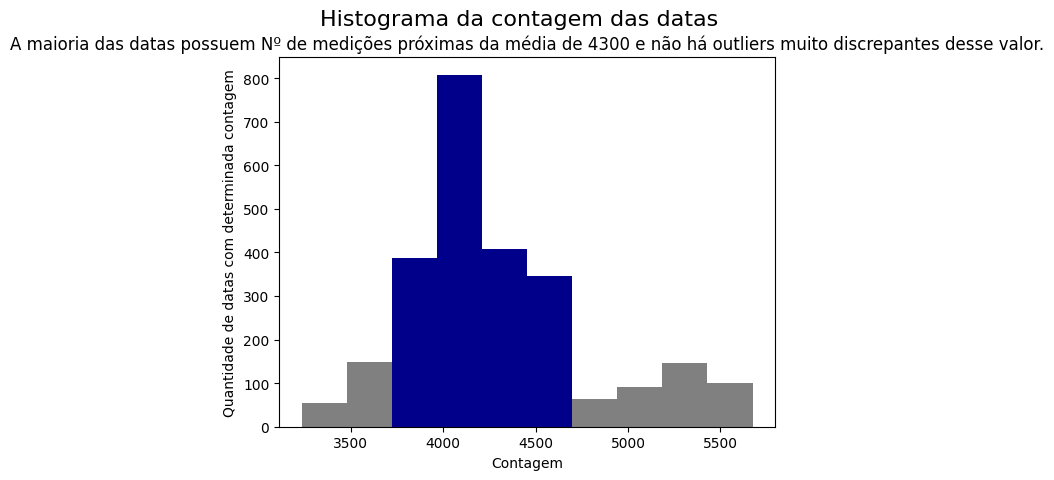

In [14]:
N, bins, patches = plt.hist(data_data_count)
plt.xlabel('Contagem')
plt.ylabel('Quantidade de datas com determinada contagem')
plt.suptitle('Histograma da contagem das datas', fontsize = '16')
plt.title('A maioria das datas possuem Nº de medições próximas da média de 4300 e não há outliers muito discrepantes desse valor.')
for i in range(2, 6):
    patches[i].set_facecolor('Darkblue')
for i in range(0, 2):
    patches[i].set_facecolor('Gray')
for i in range(6, len(patches)):
    patches[i].set_facecolor('Gray')

### Hora

Verificando se não há valores nulos.

In [15]:
data['Hora'].isnull().value_counts()

False    10980515
Name: Hora, dtype: int64

In [16]:
data_hour_count = data['Hora'].value_counts().sort_index()

In [17]:
data_hour_count.describe()

count        24.000000
mean     457521.458333
std       24894.142328
min      379531.000000
25%      465003.000000
50%      467204.500000
75%      468774.750000
max      469259.000000
Name: Hora, dtype: float64

Por esses valores, vemos que todas as horas do dia possuem medições de poluentes catalogadas. Além disso, vemos que o valor mínimo é distante do 1º quartil, indicando que algumas horas do dia possuem medições bastante abaixo da mediana. Podemos verificar isso em um boxplot:

Text(0.5, 1.0, 'Há 5 horários outliers em termos de quantidade de medições.')

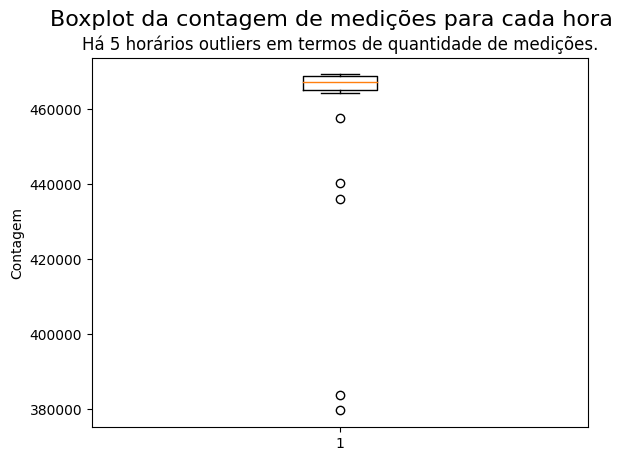

In [18]:
plt.boxplot(data_hour_count)
plt.ylabel('Contagem')
plt.suptitle('Boxplot da contagem de medições para cada hora', fontsize = '16')
plt.title('Há 5 horários outliers em termos de quantidade de medições.')

Com ele, podemos ver que há horas do dia em que tivemos medições abaixo da maioria. Podemos descobrir quais são fazendo:

In [19]:
hour_first_quartile = data_hour_count.quantile(0.25)
hour_third_quartile = data_hour_count.quantile(0.75)
inter_dist = hour_third_quartile - hour_first_quartile # Distância interquartílica.
data_hour_count[data_hour_count < hour_first_quartile - 1.5*(inter_dist)]

01:00    383679
02:00    457630
04:00    440328
05:00    435875
06:00    379531
Name: Hora, dtype: int64

Vemos que são justamente os horários da madrugada/começo da manhã.

### Estação e Código

Estação e Código possuem relação de 1:1, então esperamos que a contagem seja a mesma.

In [20]:
data_station_count = data['Estacao'].value_counts()

In [21]:
data_code_count = data['Codigo'].value_counts()

In [22]:
data_station_count.describe()

count        90.000000
mean     122005.722222
std       94709.725805
min          27.000000
25%         413.250000
50%      139536.500000
75%      194896.000000
max      287897.000000
Name: Estacao, dtype: float64

In [23]:
data_code_count.describe()

count        87.000000
mean     126212.816092
std       93787.137514
min          27.000000
25%       15668.500000
50%      144612.000000
75%      198590.500000
max      287897.000000
Name: Codigo, dtype: float64

Vemos que não acontece o esperado: temos uma contagem de códigos menor que a de estações. Vamos tentar buscar o porquê, analisando:

- Presença de valores nulos.
- Presença de códigos iguais para diferentes localidades.

Presença de valores nulos

In [24]:
data[data['Codigo'].isnull() == True]

,ID,Data,Hora,Estacao,Codigo,Poluente,Valor,Unidade,Tipo


Não há valores nulos na coluna 'Codigo'.

Presença de códigos iguais para diferentes localidades

In [25]:
query('''
    SELECT x.Codigo, x.Estacao 
    FROM 
        (SELECT DISTINCT Codigo, Estacao FROM data) x,
        (SELECT DISTINCT Codigo, Estacao FROM data) y
    WHERE x.Codigo = y.Codigo
    AND x.Estacao <> y.Estacao
    ORDER BY x.Codigo
''')

,Codigo,Estacao
0,SP04,Guaratinguetá
1,SP04,Guaratingueta
2,SP17,Cordeirópolis - Módolo
3,SP17,Cordeiropolis - Modolo
4,SP23,Guarujá - Vicente de Carvalho
5,SP23,Guaruja - Vicente de Carvalho


Achamos o problema! Vamos corrigí-lo adicionando acentos em todas as estações sem acento.

In [26]:
data.loc[data['Estacao'] == 'Guaratingueta', 'Estacao'] = 'Guaratinguetá'
data.loc[data['Estacao'] == 'Cordeiropolis - Modolo', 'Estacao'] = 'Cordeirópolis - Módolo'
data.loc[data['Estacao'] == 'Guaruja - Vicente de Carvalho', 'Estacao'] = 'Guarujá - Vicente de Carvalho'

Atualizando as variáveis

In [27]:
data_station_count = data['Estacao'].value_counts()
data_code_count = data['Codigo'].value_counts()

In [28]:
data_station_count.describe()

count        87.000000
mean     126212.816092
std       93787.137514
min          27.000000
25%       15668.500000
50%      144612.000000
75%      198590.500000
max      287897.000000
Name: Estacao, dtype: float64

In [29]:
data_code_count.describe()

count        87.000000
mean     126212.816092
std       93787.137514
min          27.000000
25%       15668.500000
50%      144612.000000
75%      198590.500000
max      287897.000000
Name: Codigo, dtype: float64

### Poluente

Verificando se não há valores nulos.

In [7]:
data['Poluente'].isnull().value_counts()

False    10980515
Name: Poluente, dtype: int64

In [8]:
pol_count = data['Poluente'].value_counts()

In [9]:
pol_count

MP10     2883216
O3       2647308
NO2      2176814
MP2.5    1224587
CO        899056
SO2       796305
NO        347840
FMC         3679
PTS         1710
Name: Poluente, dtype: int64

In [33]:
pol_count.describe()

count    9.000000e+00
mean     1.220057e+06
std      1.102603e+06
min      1.710000e+03
25%      3.478400e+05
50%      8.990560e+05
75%      2.176814e+06
max      2.883216e+06
Name: Poluente, dtype: float64

Temos 9 poluentes distintos. Notamos que o MP10, o O3 e o NO2 são aqueles que, de longe, são os mais medidos. Enquanto isso, estações medindo FMC e PTS são muito escassas. Podemos verificar a distribuição do número medições através de um histograma:

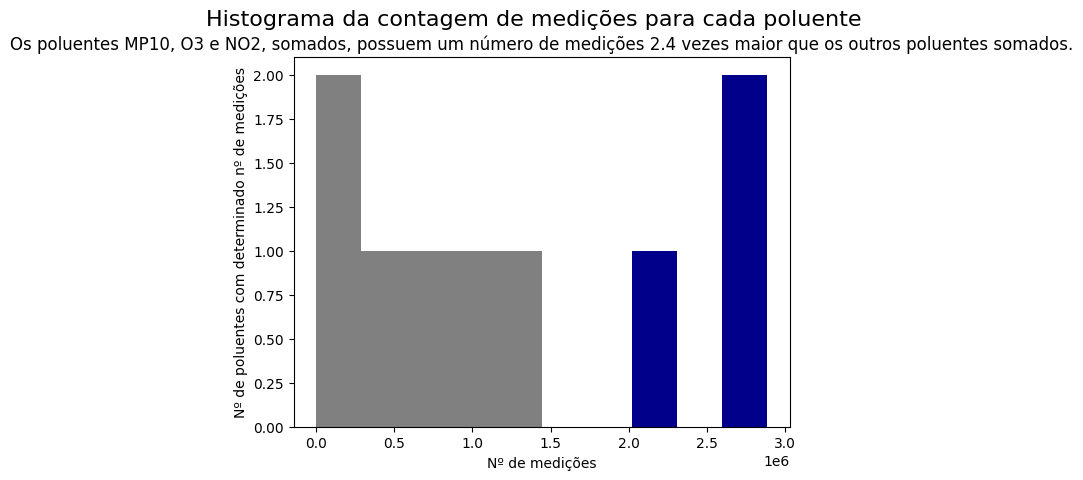

In [11]:
N, bins, patches = plt.hist(pol_count)
plt.xlabel('Nº de medições')
plt.ylabel('Nº de poluentes com determinado nº de medições')
plt.suptitle('Histograma da contagem de medições para cada poluente', fontsize = '16')
more_measures = ['MP10', 'O3', 'NO2']
less_measures = ['MP2.5', 'CO', 'SO2', 'NO', 'FMC', 'PTS']
more_measures_rate = sum(pol_count[more_measures])/(sum(pol_count[less_measures]))
plt.title(f'Os poluentes MP10, O3 e NO2, somados, possuem um número de medições {round(more_measures_rate,1)} vezes maior que os outros poluentes somados.')
patches[len(patches) - 1].set_facecolor('Darkblue')
patches[len(patches) - 3].set_facecolor('Darkblue')
for i in range(0, len(patches) - 3):
    patches[i].set_facecolor('Gray')

### Unidade

In [35]:
data['Unidade'].value_counts()

ug/m3    10980515
Name: Unidade, dtype: int64

Todos os valores de concentração são medidos em $\frac{\mu g}{m^{3}}$ (microgramas por metro cúbico) de poluente.

### Tipo

In [36]:
type_count = data['Tipo'].value_counts()

In [37]:
type_count

automatica    10971842
manual            8673
Name: Tipo, dtype: int64

A extensa maioria das medições foi feita automaticamente. É curioso sabermos em que lugares foram feitas as medições automáticas e as manuais, e quantas foram feitas em cada lugar.

In [38]:
auto_measure_count = data[data['Tipo'] == 'automatica']['Estacao'].value_counts()

In [39]:
manual_measure_count = data[data['Tipo'] == 'manual']['Estacao'].value_counts()

In [40]:
auto_len = len(auto_measure_count)
manual_len = len(manual_measure_count)

In [41]:
print(f'Número de locais com medição automática: {auto_len}')
print(f'Número de locais com medição manual: {manual_len}')

Número de locais com medição automática: 65
Número de locais com medição manual: 33


Text(0.5, 1.0, 'A maioria dos locais utiliza medições automáticas, as quais caracterizam 99.9% das medições de poluentes.')

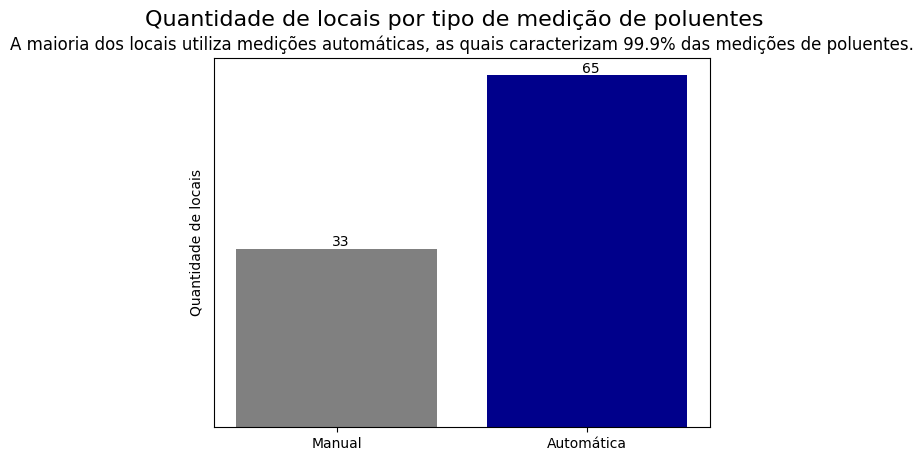

In [45]:
x = np.array(['Manual', 'Automática'])
y = np.array([manual_len, auto_len])
plt.bar(x, y, color = ['Grey', 'Darkblue'])
plt.yticks([])
plt.ylabel('Quantidade de locais')
plt.text(0 - 0.02, manual_len + 0.5, s = f'{manual_len}')
plt.text(1 - 0.02, auto_len + 0.5, s = f'{auto_len}')
auto_percentage = type_count['automatica']/(type_count['automatica'] + type_count['manual']) * 100
plt.suptitle('Quantidade de locais por tipo de medição de poluentes', fontsize = '16')
plt.title(f'A maioria dos locais utiliza medições automáticas, as quais caracterizam {round(auto_percentage, 1)}% das medições de poluentes.')

Como auto está em uma quantidade muito grande, printaremos apenas head e tail.

In [43]:
print(f'Head auto count:\n\n{auto_measure_count.head()}\n')
print(f'Tail auto count:\n\n{auto_measure_count.tail()}')

Head auto count:

Santos - Ponta da Praia           287897
Marg. Tietê - Pte dos Remédios    286482
Parque Dom Pedro II               286121
Congonhas                         280515
Guarulhos - Pimentas              275144
Name: Estacao, dtype: int64

Tail auto count:

Perus                           57384
Americana                       56578
Americana - Vila Santa Maria    49320
Itaquera                        47968
Mogi das Cruzes - Centro        30923
Name: Estacao, dtype: int64


Como manual está em menor quantidade, printaremos todos os seus valores.

In [44]:
print(f'Manual count:\n\n{manual_measure_count}')

Manual count:

Cerqueira César                    1085
Pinheiros                           555
Ibirapuera                          494
Campos Elíseos                      414
Tatuapé                             413
Cordeirópolis - Módolo              361
Santa Gertrudes - Jd. Luciana       353
Sorocaba - Centro                   342
Salto - Centro                      342
Itu - Centro                        324
Jaboticabal - Jd Kennedy            304
Jundiaí - Centro                    304
Franca - Cidade Nova                300
Guarujá - Vicente de Carvalho       288
Osasco                              287
Santo Amaro                         281
São Carlos - Centro                 246
Santo André - Capuava               240
São Bernardo do Campo               224
Cubatão - Vila Parisi               208
Rio Claro - Jardim Guanabara        204
Piracicaba - Algodoal               180
Marg. Tietê - Pte dos Remédios      152
Limeira - Boa Vista                 140
Limeira - Centro         

### Valor

In [12]:
data['Valor'].describe()

count    1.098052e+07
mean     8.330876e+01
std      2.500071e+02
min      0.000000e+00
25%      9.000000e+00
50%      2.200000e+01
75%      4.500000e+01
max      9.981292e+03
Name: Valor, dtype: float64

Aqui notamos que os valores de concentrações possuem:

- Desvio-padrão muito elevado, de 250, ou seja, dados muito dispersos;
- Média de 83,3;
- 25% dos valores menores ou iguais a 9;
- 50% dos valores menores ou iguais a 22;
- 75% dos valores menores ou iguais a 45;
- Máximo extremamente elevado, de 9981.
- Mínimo igual a 0.

Assim, temos dados com valores muito diversificados e com concentração de valores muito grande para valores pequenos ($ <= 45\frac{\mu g}{m^{3}}$). Os outliers, enquanto isso, são extremamente discrepantes do restante dos dados, contribuindo para o alto desvio-padrão observado.

Para conseguirmos observar bem a distribuição em cada intervalo de valores, teremos que verificar vários histogramas. Antes disso, verifiquemos como se comporta o boxplot:

{'whiskers': [<matplotlib.lines.Line2D at 0x1fc13361950>,
 'caps': [<matplotlib.lines.Line2D at 0x1fc1ba64290>,
 'boxes': [<matplotlib.lines.Line2D at 0x1fc1ba2df90>],
 'medians': [<matplotlib.lines.Line2D at 0x1fc1ba76010>],
 'fliers': [<matplotlib.lines.Line2D at 0x1fc1ba76750>],
 'means': []}

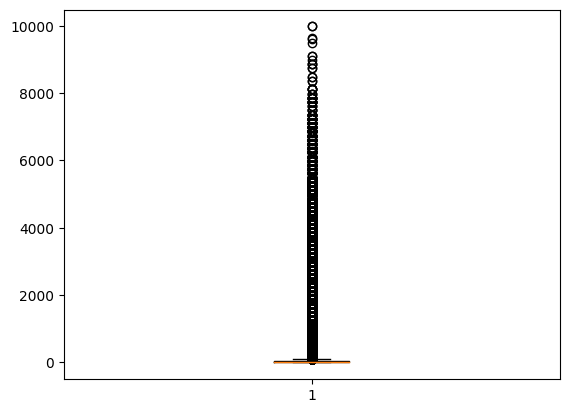

In [15]:
plt.boxplot(data['Valor'])

Vemos que, devido à quantidade imensa de dados (mais de 10 milhões) e à grande dispersão dos dados, com presença de outliers muito grandes, o boxplot se comporta de forma que não conseguimos enxergar bem os valores nos quartis. Podemos, no entanto, verificar que, de fato, há outliers extremamente fora dos valores comumente encontrados no conjunto de dados.

Vamos verificar agora os histogramas para diferentes intervalos. Iremos analisar, por enquanto, 3 histogramas distintos:

- Histograma de todos os dados (visão geral);
- Histograma dos valores <= 3º quartil = 45;
- Histograma dos valores >= 3º quartil = 45;

In [26]:
third_quartile = data['Valor'].quantile(0.75)

(array([2.658657e+06, 1.340360e+05, 1.874300e+04, 5.233000e+03,
        1.669000e+03, 5.840000e+02, 2.280000e+02, 5.800000e+01,
        1.500000e+01, 7.000000e+00]),
 array([  45.       , 1038.6291759, 2032.2583518, 3025.8875277,
        4019.5167036, 5013.1458795, 6006.7750554, 7000.4042313,
        7994.0334072, 8987.6625831, 9981.291759 ]),
 <BarContainer object of 10 artists>)

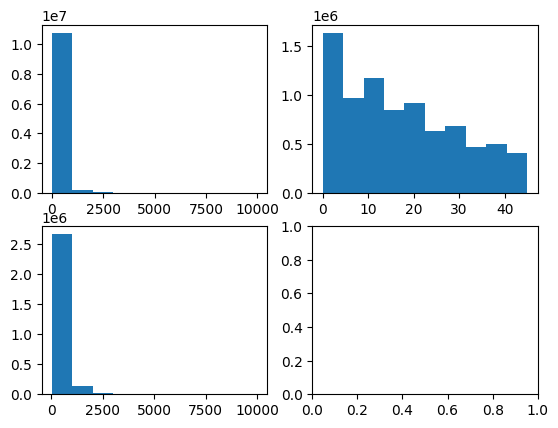

In [75]:
fig, axs = plt.subplots(2, 2)
axs[0,0].hist(data['Valor'])
axs[0,1].hist(data[data['Valor'] <= third_quartile]['Valor'])
axs[1,0].hist(data[data['Valor'] >= third_quartile]['Valor'])

Com isso, podemos verificar que ainda há muitos valores maiores que o terceiro quartil, em relação aos outliers. Iremos plotar novos histogramas:

- Histograma dos valores v tais que 45 <= v <= 45 + 1.5*dist_interquartilica
- Histograma dos valores v tais que v >= 45 + 1.5*dist_interquartilica

In [45]:
first_quartile = data['Valor'].quantile(0.25)
inter_dist = (third_quartile - first_quartile)

(array([9.62378e+05, 1.34036e+05, 1.87430e+04, 5.23300e+03, 1.66900e+03,
        5.84000e+02, 2.28000e+02, 5.80000e+01, 1.50000e+01, 7.00000e+00]),
 array([  99.       , 1087.2291759, 2075.4583518, 3063.6875277,
        4051.9167036, 5040.1458795, 6028.3750554, 7016.6042313,
        8004.8334072, 8993.0625831, 9981.291759 ]),
 <BarContainer object of 10 artists>)

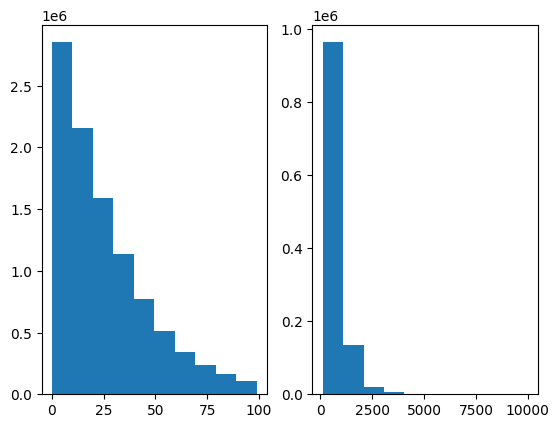

In [77]:
fig, axs = plt.subplots(1, 2)
axs[0].hist(data[(data['Valor'] <= 45 + 1.5*inter_dist)]['Valor'])
axs[1].hist(data[data['Valor'] >= 45 + 1.5*inter_dist]['Valor'])

Por fim, iremos obter mais dois histogramas separando os maiores outliers:

- Histograma dos valores v tais que 45 + 1.5*inter_dist <= v <= 1000
- Histograma dos valores >= 1000

(array([1.34036e+05, 1.75520e+04, 5.60200e+03, 2.01700e+03, 8.62000e+02,
        3.22000e+02, 1.28000e+02, 3.70000e+01, 1.00000e+01, 7.00000e+00]),
 array([1122.89532294, 2008.73496655, 2894.57461015, 3780.41425376,
        4666.25389736, 5552.09354097, 6437.93318458, 7323.77282818,
        8209.61247179, 9095.45211539, 9981.291759  ]),
 <BarContainer object of 10 artists>)

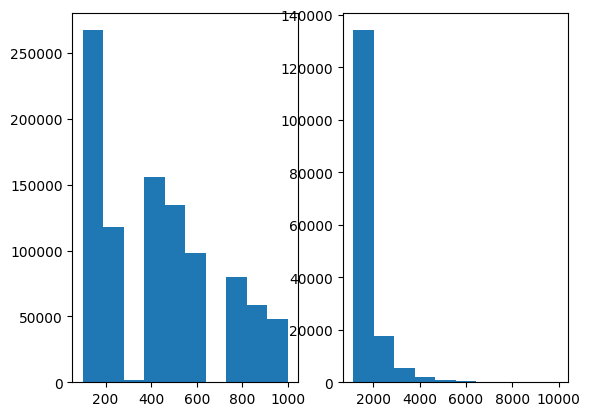

In [78]:
fig, axs = plt.subplots(1, 2)
axs[0].hist(data[(data['Valor'] >= 45 + 1.5*inter_dist) & (data['Valor'] <= 1000)]['Valor'])
axs[1].hist(data[(data['Valor'] >= 1000)]['Valor'])

---